# Homework 6 - Generative Adversarial Network
This is the sample code for hw6 of 2022 Machine Learning course in National Taiwan University.

In this sample code, there are 5 sections:
1. Environment setting
2. Dataset preparation
3. Model setting
4. Train
5. Inference

Your goal is to do anime face generation, if you have any question, please discuss at NTU COOL

<font color = red size = 10>StyleGAN只改了生成器，没有改判别器，望周知</font>

<font size = 10 color = red> 以后记住，所有在forward中自己生成的大矩阵要直接在GPU上生成, i.e. `torch.tensor([···], devise = 'cuda')`</font>

# Environment setting
In this section, we will prepare for the dataset and set some environment variable

## Download Dataset

In [196]:
data_path = '../faces'
# get dataset from huggingface hub
#!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | bash
#!apt-get install git-lfs
#!git lfs install
#!git clone https://huggingface.co/datasets/LeoFeng/MLHW_6
#!unzip ./MLHW_6/faces.zip -d .

## Other setting

In [197]:
# import module
import os
import glob
import random
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable, grad # 这个grad函数是pytorch的自动求导函数，用于计算gradient penalty
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import logging
from tqdm import tqdm


# seed setting
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(4595)
workspace_dir = '.'

# Dataset preparation
In this section, we prepare for the dataset for Pytorch

## Create dataset for Pytorch

In order to unified image information, we use the transform function to:
1. Resize image to 64x64
2. Normalize the image

This CrypkoDataset class will be use in Section 4

In [198]:
# prepare for CrypkoDataset

class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = torchvision.io.read_image(fname)
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

## Show the image
Show some sample in the dataset

2024-02-29 23:30 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


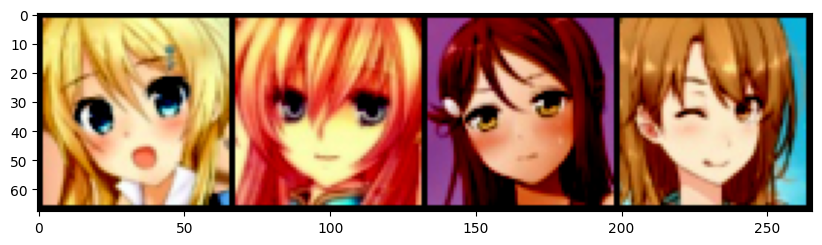

In [199]:
temp_dataset = get_dataset(os.path.join(workspace_dir, data_path))

images = [temp_dataset[i] for i in range(4)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

# Model setting
In this section, we will create models and trainer.

## Create model
In this section, we will create models for Generator and Discriminator

In [200]:
# Mapping（StyleGAN）

class MappingGenerator(nn.Module):
    """
    Input: 无
    Output shape: (batch, style_dim)
    """
    def __init__(self, config):
        '''
        暂时random input与GAN的输入共用
        '''
        super().__init__()
        self.config = config
        self.z_dim = self.config["z_dim"]
        self.style_dim = self.config["style_dim"]
        self.model = nn.Sequential (
            self.FC_block(self.z_dim, 1024),
            self.FC_block(1024, 2048),
            self.FC_block(2048, 1024),
            self.FC_block(1024, 1024),
            self.FC_block(1024, 1024),
            self.FC_block(1024, 1024),
            self.FC_block(1024, 1024),
            nn.Linear(1024, self.style_dim) # 输出
        )

    def FC_block(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU()
        )

    def forward(self, random_input):
        return self.model.forward(random_input)

In [201]:
# AdIN 归一化层
class AdIN(nn.Module):
    def __init__(self, mapping_dim, channel) -> None:
        '''
        用于计算AdIN的公式
        '''
        super().__init__()
        # 为每个通道生成缩放因子和偏移因子
        self.affine_scale = nn.Linear(mapping_dim, channel)
        self.affine_shift = nn.Linear(mapping_dim, channel)
    def forward(self, x : torch.Tensor, mapping : torch.Tensor):
        '''
        输入的x应该是 [B, C, N, N]
        '''
        B, C, _, _ = x.shape
        A_scale = self.affine_scale(mapping).view(B, C, 1, 1)
        A_shift = self.affine_shift(mapping).view(B, C, 1, 1)
        mean = x.mean([2, 3], keepdim=True)
        var = x.var([2, 3], keepdim=True) + 1e-8  # 避免除以零
        normalized = (x - mean) / torch.sqrt(var)
        out = A_scale * normalized + A_shift
        return out
        


        

In [202]:
# NoiseLayer

class NoiseLayer(nn.Module):
    """
    Input : 无
    Output : 与给定的维度相同的高斯噪声
    """
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(0.1 * torch.randn(1, 1)), requires_grad = True) # 可学习权重

    def forward(self, x : torch.Tensor):
        noise = torch.normal(mean=0, std=0.2, size=x.shape, device = 'cuda') # 这样才快！！！！
        return x + self.a * noise

In [203]:
# Generator

class Generator(nn.Module):
    """
    Input shape: (batch, in_dim)
    Output shape: (batch, 3, 64, 64)
    """
    def __init__(self, in_dim, config, feature_dim=64):
        super().__init__()
        self.config = config
        self.feature_dim = feature_dim
        self.mapping_dim = config["style_dim"]
        self.M_g = MappingGenerator(config) # Mapping直接集成到Generator里面！！！！
        self.random_block = None
        #input: (batch, 100)
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, feature_dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(feature_dim * 8 * 4 * 4),
            nn.ReLU(),
        )
       
        self.l21 = self.dconv_bn_relu(feature_dim * 8, feature_dim * 4)             #(batch, feature_dim * 16, 8, 8)
        self.l21_adin = AdIN(mapping_dim = self.mapping_dim, channel = feature_dim * 4) # outputsize: feature_dim * 4
        self.l22 = self.dconv_bn_relu(feature_dim * 4, feature_dim * 2)             #(batch, feature_dim * 16, 16, 16)
        self.l22_adin = AdIN(mapping_dim = self.mapping_dim, channel = feature_dim * 2)
        self.l23 = self.dconv_bn_relu(feature_dim * 2, feature_dim)                 #(batch, feature_dim * 16, 32, 32)
        self.l23_adin = AdIN(mapping_dim = self.mapping_dim, channel = feature_dim)
        
        self.l3 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, 3, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False), # 注意，在生成的时候我们用转置卷积！！！！，用于上采样
            nn.Tanh(),
        )
        self.apply(weights_init)
    def dconv_bn_relu(self, in_dim, out_dim):
        return nn.Sequential(
            NoiseLayer(), # 自己定义的NoiseLayer， 每一层都加一个噪声
            nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),        #double height and width
            #nn.BatchNorm2d(out_dim), # StyleGAN前一定一定，不能用batchnorm！！！！！！！！！！！
            nn.ReLU(True), # inplace = true, 为了减少内存，反卷积非常非常耗内存！！！！
        )
    
    def forward(self, x, rand_z): # 为了Style
        mapping = self.M_g(rand_z) # 首先获取mapping
        B = mapping.shape[0] # 获取mapping的Batch维度作为对输入的常数x的复制（对所有batch都要同一个输入！）
        x = torch.randn(B, self.config["z_dim"], device = 'cuda')  
        y = self.l1(rand_z) # 先对输入进行一个Linear transform
        self.random_block = x # 更新random block
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l21(y)
        y = self.l21_adin(y, mapping)
        y = self.l22(y)
        y = self.l22_adin(y, mapping)
        y = self.l23(y)
        y = self.l23_adin(y, mapping)
        y = self.l3(y)
        return y

In [204]:
# Discriminator
class Discriminator(nn.Module):
    """
    Input shape: (batch, 3, 64, 64)
    Output shape: (batch)
    """
    def __init__(self, config, in_dim, feature_dim=64):
        super(Discriminator, self).__init__()

        #input: (batch, 3, 64, 64)
        """
        NOTE FOR SETTING DISCRIMINATOR:

        Remove last sigmoid layer for WGAN
        """
        self.config = config # 记录具体是什么GAN
        self.l1 = nn.Sequential(
            nn.Conv2d(in_dim, feature_dim, kernel_size=4, stride=2, padding=1), #(batch, 3, 32, 32)
            nn.LeakyReLU(0.2),
        )
        self.l21 = self.conv_bn_lrelu(feature_dim, feature_dim * 2)                   #(batch, 3, 16, 16) 
        self.l22 = self.conv_bn_lrelu(feature_dim * 2, feature_dim * 4)               #(batch, 3, 8, 8)
        self.l23 = self.conv_bn_lrelu(feature_dim * 4, feature_dim * 8)               #(batch, 3, 4, 4)
        if (self.config["model_type"] == 'GAN'):
            self.l3 = nn.Sequential(
                nn.Conv2d(feature_dim * 8, 1, kernel_size=4, stride=1, padding=0),
                nn.Sigmoid()
            )
        else: # 所有WGAN都不能有Sigmoid
            self.l3 = nn.Sequential(
                nn.Conv2d(feature_dim * 8, 1, kernel_size=4, stride=1, padding=0),
            )
        self.apply(weights_init)
    def conv_bn_lrelu(self, in_dim, out_dim):
        
        '''
        对于WGAN-gp的判别器，是不能加 batchNorm 的，
        原因很简单， 是因为WGAN-gp的惩罚项计算中，惩罚的是单个数据的gradient norm，如果使用 batchNorm，就会扰乱这种惩罚，让这种特别的惩罚失效。 
        当然你可以绕过 batchNorm, 使用 layerNorm 或者 InstanceNorm
        '''
        """
        NOTE FOR SETTING DISCRIMINATOR:

        You can't use nn.Batchnorm for WGAN-GP
        Use nn.InstanceNorm2d instead
        """
        if (self.config["model_type"] == 'WGAN-GP'):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 4, 2, 1),
                nn.InstanceNorm2d(out_dim), 
                nn.LeakyReLU(0.2),
            )
        
        return nn.Sequential( # 如果不是
            nn.Conv2d(in_dim, out_dim, 4, 2, 1),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x): # mapping 为了style
        y = self.l1(x)
        y = self.l21(y)
        y = self.l22(y)
        y = self.l23(y)
        y = self.l3(y)
        y = y.view(-1)
        return y

In [205]:
# setting for weight init function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Create trainer
In this section, we will create a trainer which contains following functions:
1. prepare_environment: prepare the overall environment, construct the models, create directory for the log and ckpt
2. train: train for generator and discriminator, you can try to modify the code here to construct WGAN or WGAN-GP
3. inference: after training, you can pass the generator ckpt path into it and the function will save the result for you

In [206]:
global_time = '' # 记录登记时间以在最后加载check point
class TrainerGAN():
    def __init__(self, config):
        self.config = config
        self.G = Generator(self.config["z_dim"], config)
        self.D = Discriminator(config = self.config, in_dim = 3)
        self.static_z = torch.randn(1, self.config["z_dim"], device = 'cuda') # for Style （注意所有batch共用一个）

        self.loss = nn.BCELoss() # 用BCELoss！！！

        """
        NOTE FOR SETTING OPTIMIZER:

        GAN: use Adam optimizer
        WGAN: use RMSprop optimizer
        WGAN-GP: use Adam optimizer
        """
        if(config["model_type"] == 'GAN'):
            self.opt_D = torch.optim.Adam(self.D.parameters(), lr=self.config["lr"], weight_decay = self.config["weight_decay"], betas=(0.5, 0.999))
            self.opt_G = torch.optim.Adam(self.G.parameters(), lr=self.config["lr"], weight_decay = self.config["weight_decay"], betas=(0.5, 0.999))
        if(config["model_type"] == 'WGAN'):
            self.opt_D = torch.optim.RMSprop(self.D.parameters(), lr=self.config["lr"], weight_decay = self.config["weight_decay"])
            self.opt_G = torch.optim.RMSprop(self.G.parameters(), lr=self.config["lr"], weight_decay = self.config["weight_decay"])
        if(config["model_type"] == 'WGAN-GP'):
            self.opt_D = torch.optim.Adam(self.D.parameters(), lr=self.config["lr"], weight_decay = self.config["weight_decay"], betas=(0.5, 0.999))
            self.opt_G = torch.optim.Adam(self.G.parameters(), lr=self.config["lr"], weight_decay = self.config["weight_decay"], betas=(0.5, 0.999))

        self.dataloader = None
        self.log_dir = os.path.join(self.config["workspace_dir"], 'logs')
        self.ckpt_dir = os.path.join(self.config["workspace_dir"], 'checkpoints')

        FORMAT = '%(asctime)s - %(levelname)s: %(message)s'
        logging.basicConfig(level=logging.INFO,
                            format=FORMAT,
                            datefmt='%Y-%m-%d %H:%M')

        self.steps = 0
        self.z_samples = torch.randn(100, self.config["z_dim"]).cuda()

    def prepare_environment(self):
        """
        Use this funciton to prepare function
        """
        global global_time
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.ckpt_dir, exist_ok=True)

        # update dir by time
        time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        global_time = time
        self.log_dir = os.path.join(self.log_dir, time+f'_{self.config["model_type"]}')
        self.ckpt_dir = os.path.join(self.ckpt_dir, time+f'_{self.config["model_type"]}')
        os.makedirs(self.log_dir)
        os.makedirs(self.ckpt_dir)

        # create dataset by the above function
        dataset = get_dataset(os.path.join(self.config["workspace_dir"], data_path))
        self.dataloader = DataLoader(dataset, batch_size=self.config["batch_size"], shuffle=True, num_workers=2)

        # model preparation
        self.G = self.G.cuda()
        self.D = self.D.cuda()
        self.G.train()
        self.D.train()
    def gp(self, r_imgs : torch.Tensor, f_imgs : torch.Tensor): # 注意，这个Variable封装是老旧的实现，可以不用了现在
        """
        Implement gradient penalty function
        r_img : [batch, 3, 64, 64]
        """
        lamb = self.config["gp_config"]["lambda"]
        eps = random.random() # 从 0 ～ 1 中随机取eps噪声

        '''
        为了gradient penalty 我们甚至还需要再前向传播一次判别器
        '''

        x_sharp : torch.Tensor = eps * r_imgs + (1 - eps) * f_imgs # 随机权重加权得出x
        x_sharp.requires_grad_() # 需要求导
        x_sharp.cuda()
        D_x_sharp = self.D.forward(x_sharp) # 前向传播
        grad_D_x_sharp = grad( # autograd.grad, 输出的是输出对于输入的tensor梯度
            outputs = D_x_sharp, # outputs：这是你想要计算梯度的输出变量。在WGAN-GP的上下文中，outputs将是判别器对插值样本的输出。这个输出是需要对其进行微分的函数。
            inputs = x_sharp, # inputs：这些是你需要计算其相对于outputs的梯度的输入变量。在WGAN-GP中，inputs将是插值样本本身。你感兴趣的是如何根据这些插值样本调整判别器的输出。
            grad_outputs=torch.ones_like(D_x_sharp).cuda(), # 这是对outputs梯度的权重。
                                                              # 在大多数情况下，如果outputs是标量（即单个数值），你可以简单地将其设置为torch.ones_like(outputs)，
                                                              # 这意味着梯度不会被加权。在WGAN-GP的应用中，这通常是你所需要的，因为我们对计算梯度的绝对值感兴趣。
            create_graph=True, # 当这个参数设置为True时，会构建用于计算梯度的计算图，这允许你随后对这些梯度再次进行微分（即进行二次微分）。在WGAN-GP中，这是必要的，因为梯度惩罚涉及到梯度的梯度（即梯度的范数的梯度）
            retain_graph=True, # 如果设置为True，这个参数允许你多次使用grad函数，而不销毁中间计算图。在某些情况下，比如在计算梯度惩罚时，你可能需要保留计算图，以便进行额外的操作。
            only_inputs=True # 当设置为True时，grad函数只会返回指定inputs的梯度，而不是所有可能的自动微分变量的梯度。在大多数情况下，这正是你所需要的，因为你通常只对特定输入的梯度感兴趣。
        )[0] #取第一个就行了
        gp = ((grad_D_x_sharp.norm(p=2, dim=(1, 2)) - 1)**2).mean().cuda() # 计算每梯度的L2范数, 求平均
        return lamb * gp #正则化值


    def train(self):
        """
        Use this function to train generator and discriminator
        """
        self.prepare_environment()

        for e, epoch in enumerate(range(self.config["n_epoch"])):
            progress_bar = tqdm(self.dataloader)
            progress_bar.set_description(f"Epoch {e+1}")
            for i, data in enumerate(progress_bar):
                imgs = data.cuda()
                bs = imgs.size(0)

                # *********************
                # *    Train D        *
                # *********************
                # 此时mapping应该没有梯度
                rand_z = torch.randn(bs, self.config["z_dim"], device = 'cuda') 
                r_imgs = imgs.cuda() # r_imgs: 真实的img
                f_imgs = self.G(self.static_z, rand_z) # f_imgs: 生成的假img (styleGAN保留固定值)
                r_label = torch.ones((bs)).cuda()
                f_label = torch.zeros((bs)).cuda()


                # Discriminator forwarding
                r_logit = self.D(r_imgs)
                f_logit = self.D(f_imgs)

                """
                NOTE FOR SETTING DISCRIMINATOR LOSS:

                GAN:
                    loss_D = (r_loss + f_loss)/2
                WGAN:
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit)
                WGAN-GP:
                    gradient_penalty = self.gp(r_imgs, f_imgs)
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + gradient_penalty
                """
                # Loss for discriminator
                if(self.config["model_type"] == 'GAN'):
                    r_loss = self.loss(r_logit, r_label)
                    f_loss = self.loss(f_logit, f_label)
                    loss_D = (r_loss + f_loss) / 2
                elif(self.config["model_type"] == 'WGAN'):
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit)
                elif(self.config["model_type"] == 'WGAN-GP'):
                    gradient_penalty = self.gp(r_imgs, f_imgs)
                    loss_D =  -torch.mean(r_logit) + torch.mean(f_logit) + gradient_penalty
                else:
                    raise NameError("please cheke the config of 'model_type' ")

                # Discriminator backwarding
                self.D.zero_grad()
                loss_D.backward()
                self.opt_D.step()

                """
                NOTE FOR SETTING WEIGHT CLIP:

                WGAN: below code
                """
                if (self.config["model_type"] == 'WGAN'):
                    for p in self.D.parameters():
                        p.data.clamp_(-self.config["clip_value"], self.config["clip_value"])



                # *********************
                # *    Train G        *
                # *********************
                if self.steps % self.config["n_critic"] == 0:
                    # Generate some fake images.
                    rand_z = torch.randn(bs, self.config["z_dim"]).cuda()
                    f_imgs = self.G(self.static_z, rand_z)

                    # Generator forwarding
                    f_logit = self.D(f_imgs)


                    """
                    NOTE FOR SETTING LOSS FOR GENERATOR:

                    GAN: loss_G = self.loss(f_logit, r_label)
                    WGAN: loss_G = -torch.mean(self.D(f_imgs))
                    WGAN-GP: loss_G = -torch.mean(self.D(f_imgs))
                    """
                    # Loss for the generator.
                    if (self.config["model_type"] == 'GAN'):
                        loss_G = self.loss(f_logit, r_label)
                    elif(self.config["model_type"] == 'WGAN'):
                        loss_G = -torch.mean(self.D(f_imgs))
                    elif(self.config["model_type"] == 'WGAN-GP'):
                        loss_G = -torch.mean(self.D(f_imgs))
                    else:
                        raise NameError("please cheke the config of 'model_type' ")

                    # Generator backwarding
                    self.G.zero_grad()
                    loss_G.backward()
                    self.opt_G.step()


                if self.steps % 10 == 0:
                    progress_bar.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())
                self.steps += 1

            self.G.eval()
            with torch.no_grad():
                f_imgs_sample = (self.G(self.static_z, self.z_samples).data + 1) / 2.0 # 用一个常数输入z
                filename = os.path.join(self.log_dir, f'Epoch_{epoch+1:03d}.jpg')
                torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
                logging.info(f'Save some samples to {filename}.')

            # Show some images during training.
            if ((e + 1) % 5 == 0 or e == 0 ): # 每隔上5次打印一次
                grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
                plt.figure(figsize=(10,10))
                plt.imshow(grid_img.permute(1, 2, 0))
                plt.show()

            self.G.train()

            if (e+1) % 10 == 0 or e == 0:
                # Save the checkpoints.
                torch.save(self.static_z,os.path.join(self.ckpt_dir, f'static_z_{e}.pth')) # 多存 
                torch.save(self.G.state_dict(), os.path.join(self.ckpt_dir, f'G_{e}.pth'))
                torch.save(self.D.state_dict(), os.path.join(self.ckpt_dir, f'D_{e}.pth'))

        logging.info('Finish training')

    def inference(self, G_path, static_z_path, M_g_path, n_generate=1000, n_output=30, show=False):
        """
        1. G_path is the path for Generator ckpt
        2. You can use this function to generate final answer
        """

        self.G.load_state_dict(torch.load(G_path))
        self.static_z = torch.load(static_z_path)
        self.G.cuda()
        self.G.eval()
        rand_z = torch.randn(n_generate, self.config["z_dim"]).cuda()
        imgs = (self.G(self.static_z, rand_z).data + 1) / 2.0

        os.makedirs('output', exist_ok=True)
        for i in range(n_generate):
            torchvision.utils.save_image(imgs[i], f'output/{i+1}.jpg')

        if show:
            row, col = n_output//10 + 1, 10
            grid_img = torchvision.utils.make_grid(imgs[:n_output].cpu(), nrow=row)
            plt.figure(figsize=(row, col))
            plt.imshow(grid_img.permute(1, 2, 0))
            plt.show()

# Train
In this section, we will first set the config for trainer, then use it to train generator and discriminator

## Set config

In [207]:
gp_config = {
    "lambda" : 10,
}

config = {
    "is_style" : True,
    "model_type": "WGAN-GP",
    "clip_value": 1, # only for WGAN, 设定clip值
    "batch_size": 128,
    "lr": 0.0001,
    "weight_decay" : 0,
    "n_epoch": 300,
    "n_critic": 2, # 多少次判别器训练才进行一次生成器训练？
    "z_dim": 512,
    "style_dim" : 512,# 解耦后的style特征
    "gp_config" : gp_config, # 用于gradient_pernalty的config
    "workspace_dir": workspace_dir, # define in the environment setting
}


## Start to train

/tmp/ipykernel_22812/3136330144.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.a = nn.Parameter(torch.tensor(0.1 * torch.randn(1, 1)), requires_grad = True) # 可学习权重
Epoch 1:   0%|          | 0/558 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 558/558 [00:41<00:00, 13.57it/s, loss_D=-128, loss_G=138]   
2024-02-29 23:31 - INFO: Save some samples to ./logs/2024-02-29_23-30-38_WGAN-GP/Epoch_001.jpg.


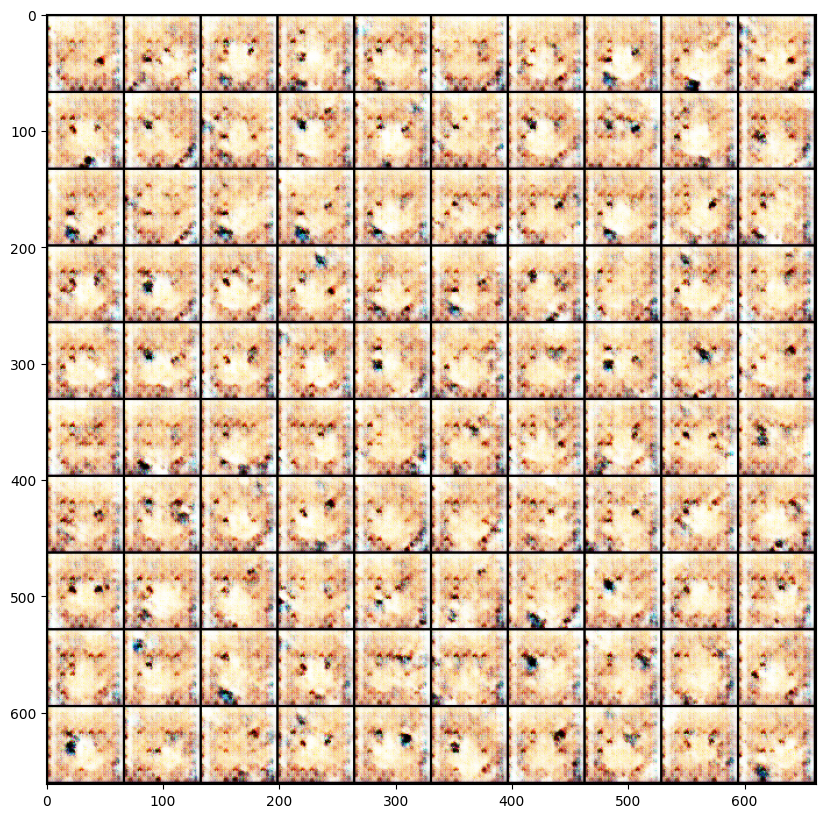

Epoch 2: 100%|██████████| 558/558 [00:41<00:00, 13.54it/s, loss_D=-286, loss_G=233]  
2024-02-29 23:32 - INFO: Save some samples to ./logs/2024-02-29_23-30-38_WGAN-GP/Epoch_002.jpg.
Epoch 3: 100%|██████████| 558/558 [00:41<00:00, 13.56it/s, loss_D=-412, loss_G=181]
2024-02-29 23:32 - INFO: Save some samples to ./logs/2024-02-29_23-30-38_WGAN-GP/Epoch_003.jpg.
Epoch 4: 100%|██████████| 558/558 [00:41<00:00, 13.55it/s, loss_D=-323, loss_G=404] 
2024-02-29 23:33 - INFO: Save some samples to ./logs/2024-02-29_23-30-38_WGAN-GP/Epoch_004.jpg.
Epoch 5:  73%|███████▎  | 409/558 [00:30<00:11, 13.44it/s, loss_D=-344, loss_G=485]

In [208]:
trainer = TrainerGAN(config)
trainer.train()

# Inference
In this section, we will use trainer to train model

## Inference through trainer

In [ ]:
# save the 1000 images into ./output folder
which_epoch = 99 # 哪个epoch?
G_path = f'{workspace_dir}/checkpoints/{global_time}_{config["model_type"]}/G_{which_epoch}.pth'
static_z_path = f'{workspace_dir}/checkpoints/{global_time}_{config["model_type"]}/static_z_{which_epoch}.pth'
M_g_path = f'{workspace_dir}/checkpoints/{global_time}_{config["model_type"]}/M_g_{which_epoch}.pth'

trainer.inference(G_path = G_path, static_z_path = static_z_path, M_g_path = M_g_path) # you have to modify the path when running this line

## Prepare .tar file for submission

In [ ]:
%cd output
!tar -zcf ../submission.tgz *.jpg
%cd ..